# Imports

In [3]:
import pandas as pd
import numpy as np

from mamimo.time_utils import add_time_features, PowerTrend
from mamimo.carryover import ExponentialCarryover
from mamimo.saturation import ExponentialSaturation

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import holidays

import seaborn as sns
import matplotlib.pyplot as plt

# Load DataFrame

In [4]:
df = pd.read_csv('../../raw_data/df.csv')
df = df.drop(columns='Unnamed: 0')
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace=True)
df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})
df['day'] = df.index # we will use this in our column transformer
df = df.drop(columns = ['fb_impressions', 'fb_clicks', 'google_impressions', 'google_clicks', 'tt_impressions', 'tt_clicks'])

# Split Data

In [5]:
n_splits = 5  # Number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(df):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

y_train = train_df['total_sales']
X_train = train_df.drop(columns = ['total_sales', 'orders'])


y_test = test_df['total_sales']
X_test = test_df.drop(columns = ['total_sales', 'orders'])

In [6]:
len(train_df)

655

In [7]:
len(test_df)

130

In [9]:
len(train_df)/(len(train_df)+len(test_df))

0.8343949044585988

In [10]:
len(test_df)/(len(train_df)+len(test_df))

0.16560509554140126

# Baseline Model

In [4]:
baseline = train_df.shift(1) # baseline['total_sales'] is equivalent to y_pred

y_pred = baseline['total_sales']
y_true = train_df['total_sales']

# MSE
mse = ((y_true - y_pred) ** 2).mean()

# Calculate TSS (Total Sum of Squares)
mean_y_true = np.mean(y_true)
tss = np.sum((y_true - mean_y_true)**2)

# Calculate RSS (Residual Sum of Squares)
rss = np.sum((y_true - y_pred)**2)

# Calculate R-squared (Coefficient of Determination)
r_squared = 1 - (rss / tss)

f"{mse} is our MSE to beat; {r_squared} is our R squared to beat!"

'595453.442743578 is our MSE to beat; 0.6398209085770498 is our R squared to beat!'

# Check for stationarity

In [5]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df.total_sales)[1] # close enough to 0.05, so our data is stationary enough

0.062198848540433505

# Create Custom Tranformers

## Time Features

### Holidays

In [6]:
class AddHolidaysTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        de_holiday_list = []
        for holiday in holidays.Germany(years=[2021,2022,2023]).items():
            de_holiday_list.append(holiday)
        de_holidays_df = pd.DataFrame(de_holiday_list, columns=["date", "holiday"])
        de_holidays_df['date'] = pd.to_datetime(de_holidays_df['date'])
        de_holidays_df.set_index('date', inplace=True)
        
        at_holiday_list = []
        for holiday in holidays.Austria(years=[2021,2022,2023]).items():
            at_holiday_list.append(holiday)
        at_holidays_df = pd.DataFrame(at_holiday_list, columns=["date", "holiday"])
        at_holidays_df['date'] = pd.to_datetime(at_holidays_df['date'])
        at_holidays_df.set_index('date', inplace=True)

        # add DE holidays to df
        merged_df = df.merge(de_holidays_df, how='left', left_index=True, right_index=True)
        merged_df['de_holiday'] = merged_df.index.isin(de_holidays_df.index).astype(int)
        merged_df.drop(columns=['holiday'], inplace=True)
        
        # add AT holidays to df
        at_holidays_df['at_holiday'] = 1 # add a 1 column to austrian holidays dataframe to help us merge with DE holidays
        merged_df = merged_df.merge(at_holidays_df[['at_holiday']], how='left', left_index=True, right_index=True)
        merged_df.head() # creates two columns (at_holiday_x, at_holiday_y), we only need one
        merged_df['at_holiday'].fillna(0, inplace=True) # replace NaN (no holiday) with 0
        merged_df['at_holiday'] = merged_df['at_holiday'].astype(int) # convert 1 and 0 to integers
        
        # combine columns
        merged_df['holiday'] = (merged_df['at_holiday'] | merged_df['de_holiday']).astype(int)
        merged_df = merged_df.drop(columns = ['de_holiday', 'at_holiday']) # drop individual DE and AT rows
        
        return merged_df[['holiday']]#.reset_index(drop=True)


#### Does it work?

In [7]:
holidays_transformer = AddHolidaysTransformer()
df = train_df.copy()
holidays_transformer.fit_transform(df)

,holiday
Day,
2021-07-01,0
2021-07-02,0
2021-07-03,0
2021-07-04,0
2021-07-05,0
...,...
2023-04-12,0
2023-04-13,0
2023-04-14,0


#### Yes!

### Weekends

In [8]:
class AddWeekendsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        weekday_values = df.index.weekday
        df['fri_sat'] = ((weekday_values == 4) | (weekday_values == 5)).astype(int)
        return df[['fri_sat']]

#### Does it work?

In [9]:
weekends_transformer = AddWeekendsTransformer()
df = train_df.copy()
weekends_transformer.fit_transform(df)

,fri_sat
Day,
2021-07-01,0
2021-07-02,1
2021-07-03,1
2021-07-04,0
2021-07-05,0
...,...
2023-04-12,0
2023-04-13,0
2023-04-14,1


#### Yes!

### Cyclical months

In [10]:
class AddMonthsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df = (df
        .pipe(add_time_features, month=True)
        .assign(trend=range(len(df))) # adds a linear trend which is only counting up from 0 to len(df). these #s will change during preprocessing
        )
        
        months_in_a_year = 12

        df['sin_MonthYear'] = np.sin(2*np.pi*(df['month'])/months_in_a_year)
        df['cos_MonthYear'] = np.cos(2*np.pi*(df['month'])/months_in_a_year)
        df.drop(columns=['month'], inplace=True)
        
        return df[['trend', 'sin_MonthYear', 'cos_MonthYear']]

#### Does it work?

In [11]:
add_months_transformer = AddMonthsTransformer()
df = train_df.copy()
add_months_transformer.fit_transform(df)

,trend,sin_MonthYear,cos_MonthYear
Day,,,
2021-07-01,0,-0.500000,-0.866025
2021-07-02,1,-0.500000,-0.866025
2021-07-03,2,-0.500000,-0.866025
2021-07-04,3,-0.500000,-0.866025
2021-07-05,4,-0.500000,-0.866025
...,...,...,...
2023-04-12,650,0.866025,-0.500000
2023-04-13,651,0.866025,-0.500000
2023-04-14,652,0.866025,-0.500000


#### Yes!

## Cost Features

### FB Cumulative Spending

In [12]:
class AddCumSpendingFBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period = 'weekly', carryover = False):
        self.period = period
        self.carryover = carryover
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self
    
    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        """Add a cumulative spending column. Select period (weekly, monthly, or quarterly).
        Indicate whether you would like to carry over the previous period in subsequent sums with sum_prev_data."""
        w_cumulative_spending = (
                    df[['facebook']]
                    .resample('W-Mon')  # Resample to weekly, starting on Mondays
                    .sum()
                )
        w_cumulative_spending_carryover = (
                    df[['facebook']]
                    .resample('W-Mon')
                    .sum()
                    .cumsum()
                )
        m_cumulative_spending = (
                    df[['facebook']]
                    .resample('M')  # Resample to monthly
                    .sum()
                )
        m_cumulative_spending_carryover = (
                    df[['facebook']]
                    .resample('M')
                    .sum()
                    .cumsum()
                )

        q_cumulative_spending = (
                    df[['facebook']]
                    .resample('Q')  # Resample to quarterly
                    .sum()
                )
        q_cumulative_spending_carryover = (
                    df[['facebook']]
                    .resample('Q')
                    .sum()
                    .cumsum()
                )

        week_values = {
            1: 6, # tuesday
            2: 5, # wednesday
            3: 4, # thursday
            4: 3, # friday
            5: 2, # saturday
            6: 1 # sunday
        }
        
        first_date = df.index[0]
        day_of_week = first_date.dayofweek
        cum_channels = ['facebook_cumulative']
        cost_channels = ['facebook']
        
        if self.carryover == False:
            if self.period == 'weekly':
                cumulative_spending_daily = w_cumulative_spending.reindex(df.index, method='ffill')                   
                # Merge the daily cumulative values back to the original DataFrame:
                df = df.join(cumulative_spending_daily, rsuffix='_cumulative')
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    selection = pd.DataFrame(df.loc[df.index[0:idx], 'facebook'])
                    df['facebook_cumulative'][0:idx] = selection['facebook'].sum()
            elif self.period == 'monthly':
                cumulative_spending_monthly = m_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_monthly, rsuffix='_cumulative')
            elif self.period == 'quarterly':
                cumulative_spending_quarterly = q_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_quarterly, rsuffix='_cumulative')
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')            

        elif self.carryover == True:
            if self.period == 'weekly':
                cumulative_spending_filled = w_cumulative_spending_carryover.reindex(df.index, method='ffill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    selection = pd.DataFrame(df.loc[df.index[0:idx], 'facebook'])
                    df['facebook_cum_carryover'][0:idx] = selection['facebook'].sum()
            elif self.period == 'monthly':
                cumulative_spending_filled = m_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            elif self.period == 'quarterly':
                cumulative_spending_filled = q_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')
                
        else:
            raise ValueError('Invalid carryover option. Choose True or False.')
            

        return df[['facebook_cumulative']]

#### Does it work?

In [13]:
cum_spending_FB_transformer = AddCumSpendingFBTransformer(period = 'weekly', carryover = False)
df = train_df.copy()
cum_spending_FB_transformer .fit_transform(df)

/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_2458/4171319227.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['facebook_cumulative'][0:idx] = selection['facebook'].sum()


,facebook_cumulative
Day,
2021-07-01,1013.95
2021-07-02,1013.95
2021-07-03,1013.95
2021-07-04,1013.95
2021-07-05,1271.42
...,...
2023-04-12,4793.34
2023-04-13,4793.34
2023-04-14,4793.34


#### Yes!

### Google Cumulative Spending

In [14]:
class AddCumSpendingGGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period = 'weekly', carryover = False):
        self.period = period
        self.carryover = carryover
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self
    
    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        # Check if the required columns exist
        """Add a cumulative spending column. Select period (weekly, monthly, or quarterly).
        Indicate whether you would like to carry over the previous period in subsequent sums with sum_prev_data."""
        w_cumulative_spending = (
                    df[['google']]
                    .resample('W-Mon')  # Resample to weekly, starting on Mondays
                    .sum()
                )
        w_cumulative_spending_carryover = (
                    df[['google']]
                    .resample('W-Mon')
                    .sum()
                    .cumsum()
                )
        m_cumulative_spending = (
                    df[['google']]
                    .resample('M')  # Resample to monthly
                    .sum()
                )
        m_cumulative_spending_carryover = (
                    df[['google']]
                    .resample('M')
                    .sum()
                    .cumsum()
                )

        q_cumulative_spending = (
                    df[['google']]
                    .resample('Q')  # Resample to quarterly
                    .sum()
                )
        q_cumulative_spending_carryover = (
                    df[['google']]
                    .resample('Q')
                    .sum()
                    .cumsum()
                )

        week_values = {
            1: 6, # tuesday
            2: 5, # wednesday
            3: 4, # thursday
            4: 3, # friday
            5: 2, # saturday
            6: 1 # sunday
        }
        
        first_date = df.index[0]
        day_of_week = first_date.dayofweek
        cum_channels = ['google_cumulative']
        cost_channels = ['google']
        
        if self.carryover == False:
            if self.period == 'weekly':
                cumulative_spending_daily = w_cumulative_spending.reindex(df.index, method='ffill')                   
                # Merge the daily cumulative values back to the original DataFrame:
                df = df.join(cumulative_spending_daily, rsuffix='_cumulative')
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    selection = pd.DataFrame(df.loc[df.index[0:idx], 'google'])
                    df['google_cumulative'][0:idx] = selection['google'].sum()
            elif self.period == 'monthly':
                cumulative_spending_monthly = m_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_monthly, rsuffix='_cumulative')
            elif self.period == 'quarterly':
                cumulative_spending_quarterly = q_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_quarterly, rsuffix='_cumulative')
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')            

        elif self.carryover == True:
            if self.period == 'weekly':
                cumulative_spending_filled = w_cumulative_spending_carryover.reindex(df.index, method='ffill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    df['google_cum_carryover'][0:idx] = selection['google'].sum()
            elif self.period == 'monthly':
                cumulative_spending_filled = m_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            elif self.period == 'quarterly':
                cumulative_spending_filled = q_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')
                
        else:
            raise ValueError('Invalid carryover option. Choose True or False.')
            

        return df[['google_cumulative']]

#### Does it work?

In [15]:
cum_spending_GG_transformer = AddCumSpendingGGTransformer(period = 'weekly', carryover = False)
df = train_df.copy()
cum_spending_GG_transformer .fit_transform(df)

/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_2458/3875066929.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['google_cumulative'][0:idx] = selection['google'].sum()


,google_cumulative
Day,
2021-07-01,2.80
2021-07-02,2.80
2021-07-03,2.80
2021-07-04,2.80
2021-07-05,3.18
...,...
2023-04-12,2185.29
2023-04-13,2185.29
2023-04-14,2185.29


#### Yes!

### TikTok Cumulative Spending

In [16]:
class AddCumSpendingTTTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period = 'weekly', carryover = False):
        self.period = period
        self.carryover = carryover
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self
    
    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        """Add a cumulative spending column. Select period (weekly, monthly, or quarterly).
        Indicate whether you would like to carry over the previous period in subsequent sums with sum_prev_data."""
        w_cumulative_spending = (
                    df[['tiktok']]
                    .resample('W-Mon')  # Resample to weekly, starting on Mondays
                    .sum()
                )
        w_cumulative_spending_carryover = (
                    df[['tiktok']]
                    .resample('W-Mon')
                    .sum()
                    .cumsum()
                )
        m_cumulative_spending = (
                    df[['tiktok']]
                    .resample('M')  # Resample to monthly
                    .sum()
                )
        m_cumulative_spending_carryover = (
                    df[['tiktok']]
                    .resample('M')
                    .sum()
                    .cumsum()
                )

        q_cumulative_spending = (
                    df[['tiktok']]
                    .resample('Q')  # Resample to quarterly
                    .sum()
                )
        q_cumulative_spending_carryover = (
                    df[['tiktok']]
                    .resample('Q')
                    .sum()
                    .cumsum()
                )

        week_values = {
            1: 6, # tuesday
            2: 5, # wednesday
            3: 4, # thursday
            4: 3, # friday
            5: 2, # saturday
            6: 1 # sunday
        }
        
        first_date = df.index[0]
        day_of_week = first_date.dayofweek
        cum_channels = ['tiktok']
        cost_channels = ['tiktok']
        
        if self.carryover == False:
            if self.period == 'weekly':
                cumulative_spending_daily = w_cumulative_spending.reindex(df.index, method='ffill')                   
                # Merge the daily cumulative values back to the original DataFrame:
                df = df.join(cumulative_spending_daily, rsuffix='_cumulative')
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    selection = pd.DataFrame(df.loc[df.index[0:idx], 'tiktok'])
                    df['tiktok_cumulative'][0:idx] = selection['tiktok'].sum()
            elif self.period == 'monthly':
                cumulative_spending_monthly = m_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_monthly, rsuffix='_cumulative')
            elif self.period == 'quarterly':
                cumulative_spending_quarterly = q_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_quarterly, rsuffix='_cumulative')
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')            

        elif self.carryover == True:
            if self.period == 'weekly':
                cumulative_spending_filled = w_cumulative_spending_carryover.reindex(df.index, method='ffill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    selection = pd.DataFrame(df.loc[df.index[0:idx], 'tiktok'])
                    df['tiktok_cum_carryover'][0:idx] = selection['tiktok'].sum()
            elif self.period == 'monthly':
                cumulative_spending_filled = m_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            elif self.period == 'quarterly':
                cumulative_spending_filled = q_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')
                
        else:
            raise ValueError('Invalid carryover option. Choose True or False.')
            

        return df[['tiktok_cumulative']]

#### Does it work?

In [17]:
cum_spending_TT_transformer = AddCumSpendingTTTransformer(period = 'weekly', carryover = False)
df = train_df.copy()
cum_spending_TT_transformer .fit_transform(df)

/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_2458/3296021123.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tiktok_cumulative'][0:idx] = selection['tiktok'].sum()


,tiktok_cumulative
Day,
2021-07-01,0.00
2021-07-02,0.00
2021-07-03,0.00
2021-07-04,0.00
2021-07-05,0.00
...,...
2023-04-12,2075.84
2023-04-13,2075.84
2023-04-14,2075.84


#### Yes!

## Sales Features

### Lag

In [18]:
class AddSalesLagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=7):
        self.period = period

    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Adds a sales lag column with the specified period."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df['sales_lag'] = df['total_sales'].shift(self.period)
        df['sales_lag'] = df['sales_lag'].bfill()  # Backfill missing values
        return df[['sales_lag']]


In [19]:
sales_lag_transformer = AddSalesLagTransformer(period = 7)
df = train_df.copy()
sales_lag_transformer.fit_transform(df)

,sales_lag
Day,
2021-07-01,414.85
2021-07-02,414.85
2021-07-03,414.85
2021-07-04,414.85
2021-07-05,414.85
...,...
2023-04-12,3173.95
2023-04-13,1865.47
2023-04-14,2133.27


### Moving Average

In [20]:
class AddSalesMovAvgTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=7):
        self.window_size = window_size

    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Adds a sales moving average column. Indicate the window size (default = 7)"""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df['sales_moving_avg'] = df['total_sales'].rolling(window=self.window_size, center=True).mean()
        df['sales_moving_avg'] = df['sales_moving_avg'].bfill()  # Backfill missing values at beginning of df
        df['sales_moving_avg'] = df['sales_moving_avg'].ffill()  # Forwardfill missing values at end of df
        return df[['sales_moving_avg']]

#### Does it work?

In [21]:
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 7)
df = train_df.copy()
sales_mov_avg_transformer.fit_transform(df)

,sales_moving_avg
Day,
2021-07-01,407.245714
2021-07-02,407.245714
2021-07-03,407.245714
2021-07-04,407.245714
2021-07-05,445.885714
...,...
2023-04-12,3026.895714
2023-04-13,3237.397143
2023-04-14,3237.397143


#### Yes!

### Exponential Smoothing

In [22]:
class AddSalesExpSmoothingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha = 0.5):
        self.alpha = alpha
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Adds a sales (exponential smoothing) column. Indicate the alpha value (default = 0.5)"""
        df = X.copy()
        smoothed_series = [df['total_sales'].iloc[0]]
        for i in range(1, len(df)):
            smoothed_value = self.alpha * df['total_sales'].iloc[i] + (1 - self.alpha) * smoothed_series[-1]
            smoothed_series.append(smoothed_value)
        df['smoothed_sales'] = smoothed_series
        return df[['smoothed_sales']]

#### Does it work?

In [23]:
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)
df = train_df.copy()
sales_exp_smoothing_transformer.fit_transform(df)

,smoothed_sales
Day,
2021-07-01,414.850000
2021-07-02,322.400000
2021-07-03,391.145000
2021-07-04,449.752500
2021-07-05,424.816250
...,...
2023-04-12,3845.153512
2023-04-13,3379.391756
2023-04-14,2557.425878


#### Yes!

## Adstock
* comes from `mamimo` package, explained [here](https://towardsdatascience.com/an-upgraded-marketing-mix-modeling-in-python-5ebb3bddc1b6)

In [24]:
adstock = ColumnTransformer(
    [
     ('facebook_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['facebook']),
     ('google_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['google']),
     ('tiktok_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['tiktok'])
])

def create_df(array: np.array):
    columns = ['orders', 'total_sales', 'facebook', 'google', 'tiktok', 'holiday',
       'fri_sat', 'trend', 'sin_MonthYear', 'cos_MonthYear',
       'google_cumulative', 'tiktok_cumulative', 'facebook_cumulative',
       'sales_lag', 'sales_moving_avg', 'smoothed_sales']
    columns_ = ['facebook','google','tiktok']
    df = pd.DataFrame(array, columns = columns_)
    datetime_series = pd.Series(
        pd.date_range("2021-07-01", periods=len(df), freq="D")
        )
    df = pd.concat([df,datetime_series],axis=1)
    df = df.set_index(0)
    df = df.rename(index={0: 'Day'})
    return df

# Instantiate Custom Transformers

In [25]:

holidays_transformer = AddHolidaysTransformer()
weekends_transformer = AddWeekendsTransformer()
add_months_transformer = AddMonthsTransformer()
cum_spending_FB_transformer = AddCumSpendingFBTransformer(period = 'weekly', carryover = False)
cum_spending_GG_transformer = AddCumSpendingGGTransformer(period = 'weekly', carryover = False)
cum_spending_TT_transformer = AddCumSpendingTTTransformer(period = 'weekly', carryover = False)
sales_lag_transformer = AddSalesLagTransformer(period = 7)
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 7)
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)

# Debug CT

## Time CT

In [26]:
time_features = ColumnTransformer(
    [
     ('holidays_pipe', Pipeline([
            ('add_holidays', AddHolidaysTransformer())
     ]), ['day']),
     ('weekends_pipe', Pipeline([
            ('add_weekends', AddWeekendsTransformer())
     ]), ['day']),
     ('months_pipe', Pipeline([
            ('add_months', AddMonthsTransformer())
     ]), ['day'])
])

In [27]:
df = train_df.copy()
transformed_df = time_features.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df, columns = ['holiday', 'weekends', 'trend', 'sin', 'cos'])
transformed_df

,holiday,weekends,trend,sin,cos
0,0.0,0.0,0.0,-0.500000,-0.866025
1,0.0,1.0,1.0,-0.500000,-0.866025
2,0.0,1.0,2.0,-0.500000,-0.866025
3,0.0,0.0,3.0,-0.500000,-0.866025
4,0.0,0.0,4.0,-0.500000,-0.866025
...,...,...,...,...,...
650,0.0,0.0,650.0,0.866025,-0.500000
651,0.0,0.0,651.0,0.866025,-0.500000
652,0.0,1.0,652.0,0.866025,-0.500000
653,0.0,1.0,653.0,0.866025,-0.500000


#### It works!

## Cost CT

In [28]:
cum_spending_feature = ColumnTransformer(
    [
     ('facebook_pipe', Pipeline([
            ('add_cum_spending_FB', cum_spending_FB_transformer)
     ]), ['facebook']),
     ('google_pipe', Pipeline([
            ('add_cum_spending_GG', cum_spending_GG_transformer)
     ]), ['google']),
     ('tiktok_pipe', Pipeline([
            ('add_cum_spending_TT', cum_spending_TT_transformer)
     ]), ['tiktok'])
])

In [29]:
df = train_df.copy()
transformed_df = cum_spending_feature.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df, columns = ['facebook', 'google', 'tiktok'])
transformed_df

,facebook,google,tiktok
0,1013.95,2.80,0.00
1,1013.95,2.80,0.00
2,1013.95,2.80,0.00
3,1013.95,2.80,0.00
4,1271.42,3.18,0.00
...,...,...,...
650,4793.34,2185.29,2075.84
651,4793.34,2185.29,2075.84
652,4793.34,2185.29,2075.84
653,4793.34,2185.29,2075.84


#### It works!

## Sales CT

In [30]:
sales_lag_transformer = AddSalesLagTransformer(period = 7)
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 7)
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)

sales_features = ColumnTransformer(
    [
     ('sales_lag_pipe', Pipeline([
            ('add_sales_lag', sales_lag_transformer)
     ]), ['total_sales']),
     ('sales_mov_avg_pipe', Pipeline([
            ('add_sales_mov_avg', sales_mov_avg_transformer)
     ]), ['total_sales']),
     ('sales_exp_smoothing_pipe', Pipeline([
            ('add_sales_exp_smoothing', sales_exp_smoothing_transformer)
     ]), ['total_sales'])
])

sales_preprocessing = Pipeline([
    ('sales_features', sales_features)
])

In [31]:
df = train_df.copy()
transformed_df = sales_preprocessing.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df)#, columns = ['facebook', 'google', 'tiktok'])
transformed_df

,0,1,2
0,414.85,407.245714,414.850000
1,414.85,407.245714,322.400000
2,414.85,407.245714,391.145000
3,414.85,407.245714,449.752500
4,414.85,445.885714,424.816250
...,...,...,...
650,3173.95,3026.895714,3845.153512
651,1865.47,3237.397143,3379.391756
652,2133.27,3237.397143,2557.425878
653,1767.01,3237.397143,1939.047939


#### It works!

# Pipeline

In [32]:
list(range(1, 11))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [33]:
model = LinearRegression()

adstock_pipeline = Pipeline([
    ('adstock', adstock)
])

time_preprocessing = Pipeline([
    ('time_features', time_features)
])

cost_preprocessing = Pipeline([
    ('cum_spending_feature', cum_spending_feature)
])

sales_preprocessing = Pipeline([
    ('sales_features', sales_features)
])

union = FeatureUnion([
    ('time_preprocessing', time_preprocessing),
    ('cost_preprocessing', cost_preprocessing),
    ('sales_preprocessing', sales_preprocessing),
    ('adstock_pipeline', adstock_pipeline)
])

pipeline = Pipeline([
    ('union', union),
    ('model', model)
])

param_grid = {
    'union__cost_preprocessing__cum_spending_feature__facebook_pipe__add_cum_spending_FB__period': ['weekly', 'monthly'],
    'union__cost_preprocessing__cum_spending_feature__facebook_pipe__add_cum_spending_FB__carryover': [True, False],
    'union__cost_preprocessing__cum_spending_feature__google_pipe__add_cum_spending_GG__period': ['weekly', 'monthly'],
    'union__cost_preprocessing__cum_spending_feature__google_pipe__add_cum_spending_GG__carryover': [True, False],
    'union__cost_preprocessing__cum_spending_feature__tiktok_pipe__add_cum_spending_TT__period': ['weekly', 'monthly'],
    'union__cost_preprocessing__cum_spending_feature__tiktok_pipe__add_cum_spending_TT__carryover': [True, False],
    'union__sales_preprocessing__sales_features__sales_lag_pipe__add_sales_lag__period': [7, 14, 21],
    'union__sales_preprocessing__sales_features__sales_mov_avg_pipe__add_sales_mov_avg__window_size': [3, 7, 10],
    'union__sales_preprocessing__sales_features__sales_exp_smoothing_pipe__add_sales_exp_smoothing__alpha': [0.2, 0.5, 0.8]
}

In [34]:
tscv = TimeSeriesSplit(n_splits= 3)
grid_search = GridSearchCV(pipeline, param_grid, cv = tscv)
grid_search.fit(train_df, y_train)

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
4536 fits failed out of a total of 5184.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2592 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwa

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('time_preprocessing',
                                                                        Pipeline(steps=[('time_features',
                                                                                         ColumnTransformer(transformers=[('holidays_pipe',
                                                                                                                          Pipeline(steps=[('add_holidays',
                                                                                                                                           AddHolidaysTransformer())]),
                                                                                                                          ['day']),
                                                                                                                         ('weekends_pipe',
                                                                                                                          Pipeline(...
                         'union__cost_preprocessing__cum_spending_feature__tiktok_pipe__add_cum_spending_TT__period': ['weekly',
                                                                                                                       'monthly'],
                         'union__sales_preprocessing__sales_features__sales_exp_smoothing_pipe__add_sales_exp_smoothing__alpha': [0.2,
                                                                                                                                  0.5,
                                                                                                                                  0.8],
                         'union__sales_preprocessing__sales_features__sales_lag_pipe__add_sales_lag__period': [7,
                                                                                                               14,
                                                                                                               21],
                         'union__sales_preprocessing__sales_features__sales_mov_avg_pipe__add_sales_mov_avg__window_size': [3,
                                                                                                                            7,
                                                                                                                            10]})

In [35]:
f"Best Parameters: {grid_search.best_params_}"

"Best Parameters: {'union__cost_preprocessing__cum_spending_feature__facebook_pipe__add_cum_spending_FB__carryover': False, 'union__cost_preprocessing__cum_spending_feature__facebook_pipe__add_cum_spending_FB__period': 'weekly', 'union__cost_preprocessing__cum_spending_feature__google_pipe__add_cum_spending_GG__carryover': False, 'union__cost_preprocessing__cum_spending_feature__google_pipe__add_cum_spending_GG__period': 'weekly', 'union__cost_preprocessing__cum_spending_feature__tiktok_pipe__add_cum_spending_TT__carryover': False, 'union__cost_preprocessing__cum_spending_feature__tiktok_pipe__add_cum_spending_TT__period': 'weekly', 'union__sales_preprocessing__sales_features__sales_exp_smoothing_pipe__add_sales_exp_smoothing__alpha': 0.8, 'union__sales_preprocessing__sales_features__sales_lag_pipe__add_sales_lag__period': 7, 'union__sales_preprocessing__sales_features__sales_mov_avg_pipe__add_sales_mov_avg__window_size': 3}"

In [36]:
best_pipeline = grid_search.best_estimator_
y_true = test_df['total_sales']
y_pred = best_pipeline.predict(test_df)
rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {best_pipeline.score(test_df, y_test)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.988110274926231, MAE: 197.35193546218747, RMSE: 288.4112138484709'

In [45]:
def plot_learning_curve(estimator, title, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, label = 'Test score')
    plt.ylabel('r2 score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves', fontsize = 18, y = 1.03)
    plt.legend()
    
    return plt

<module 'matplotlib.pyplot' from '/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/matplotlib/pyplot.py'>

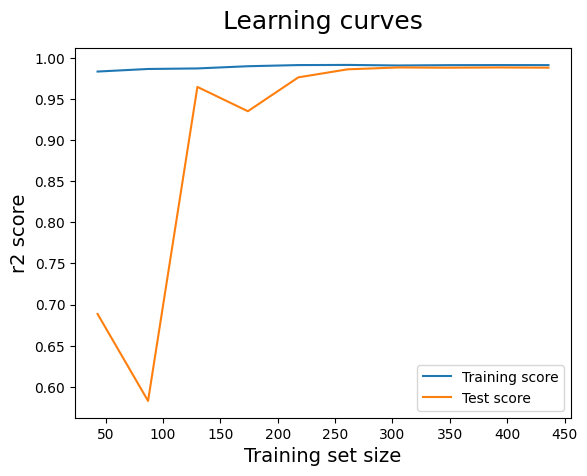

In [46]:
plot_learning_curve(best_pipeline, 'learning curve', train_df, y_train, cv = 3)

## Check pipeline output

In [47]:
# Check pipeline output as a pandas DataFrame (first you must remove ('model', model) from pipeline!)
pipeline = Pipeline([
    ('union', union)
])

pipeline.fit(train_df, y_train)

pipe_df = pd.DataFrame(pipeline.transform(train_df))
pipe_df.columns = ['holiday','weekend', 'lag','sin_months', 'cos_months', 'cum_fb', 'cum_gg', 'cum_tt', 'sales_lag', 'sales_mov_avg', 'sales_smoothed', 'adstock_fb', 'adstock_gg', 'adstock_tt']
#pipe_df

## Check for collinearity

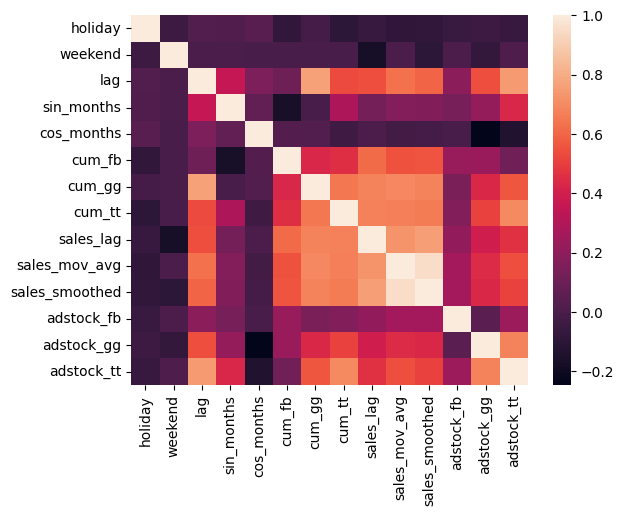

In [48]:
sns.heatmap(pipe_df.corr());

## Fit and Score on Test

In [49]:
# change pipeline back to original (including model) to fit and score

pipeline = Pipeline([
    ('union', union),
    ('model', model)
])

pipeline.fit(train_df, y_train)
f"R-squared: {pipeline.score(test_df, y_test)}"

'R-squared: 0.9074845421851194'

<module 'matplotlib.pyplot' from '/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/matplotlib/pyplot.py'>

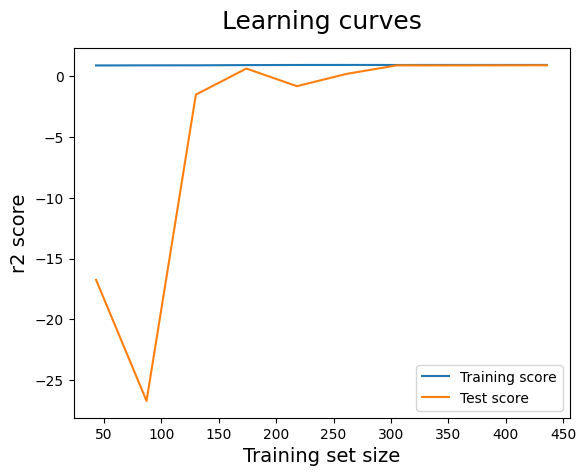

In [50]:
plot_learning_curve(pipeline, 'learning curve', train_df, y_train, cv = 3)

### Check errors

#### Test data

In [51]:
y_true = test_df['total_sales']
y_pred = pipeline.predict(test_df)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {pipeline.score(test_df, y_test)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.9074845421851194, MAE: 537.7172556474466, RMSE: 804.513594754282'

#### Train data

In [52]:
y_true = train_df['total_sales']
y_pred = pipeline.predict(train_df)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {pipeline.score(train_df, y_train)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.9380838991092426, MAE: 201.44367536269786, RMSE: 319.69414313113646'